<a href="https://colab.research.google.com/github/virslaan/TechHub---By-Vipul-Rules/blob/main/TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.862475891000031
GPU (s):
0.10837535100017703
GPU speedup over CPU: 35x


In [4]:
import tensorflow as tf
from PIL import Image

# Load the image using PIL
image = Image.open("/content/IMG_8976.JPG")

# Resize the image to a desired size
resized_image = image.resize((224, 224))

# Convert the image to a NumPy array
image_array = tf.keras.preprocessing.image.img_to_array(resized_image)

# Preprocess the image for a specific model
preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image_array)

# Load the pre-trained VGG16 model
model = tf.keras.applications.vgg16.VGG16(weights="imagenet")

# Make predictions on the preprocessed image
predictions = model.predict(tf.expand_dims(preprocessed_image, axis=0))

# Get the top 5 predicted labels and their probabilities
decoded_predictions = tf.keras.applications.vgg16.decode_predictions(predictions, top=5)[0]

# Print the top predictions
for label, _, probability in decoded_predictions:
    print(f"{label}: {probability:.4f}")

    # Print the top predictions
for imagenet_id, name, probability in decoded_predictions:
    print(f"{name}: {probability:.4f}")

1/1 [==============================] - 1s 734ms/step
n04356056: 0.4458
n04355933: 0.2451
n07892512: 0.0255
n04404412: 0.0213
n07930864: 0.0196
sunglasses: 0.4458
sunglass: 0.2451
red_wine: 0.0255
television: 0.0213
cup: 0.0196


## For your data set - use relevant dataset paths

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Load the tf_flowers dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Apply data normalization and augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
])

# Shuffle and batch the data
train_batches = train.shuffle(1000).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Build the model
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze the base model

model = Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(metadata.features['label'].num_classes)
])

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Train the model
history = model.fit(train_batches, 
                    validation_data=validation_batches, 
                    epochs=5)

# Fine-tune the base model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  5 + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/5
92/92 [==============================] - 30s 131ms/step - loss: 1.6130 - accuracy: 0.2435 - val_loss: 1.5964 - val_accuracy: 0.2698
Epoch 2/5
92/92 [==============================] - 8s 76ms/step - loss: 1.6027 - accuracy: 0.2561 - val_loss: 1.5929 - val_accuracy: 0.2752
Epoch 3/5
92/92 [==============================] - 8s 73ms/step - loss: 1.5888 - accuracy: 0.2674 - val_loss: 1.5663 - val_accuracy: 0.2698
Epoch 4/5
92/92 [==============================] - 8s 80ms/step - loss: 1.5842 - accuracy: 0.2813 - val_loss: 1.5907 - val_accuracy: 0.1689
Epoch 5/5
92/92 [==============================] - 8s 84ms/step - loss: 1.5802 - accuracy: 0.2875 - val_loss: 1.5731 - val_accuracy: 0.2125
Epoch 5/15
92/92 [==============================] - 73s 291ms/step - loss: 1.4796 - accuracy: 0.3689 - v

In [2]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_batches)

print("Test accuracy :", accuracy)

12/12 [==============================] - 3s 122ms/step - loss: 0.3324 - accuracy: 0.9019
Test accuracy : 0.9019073843955994


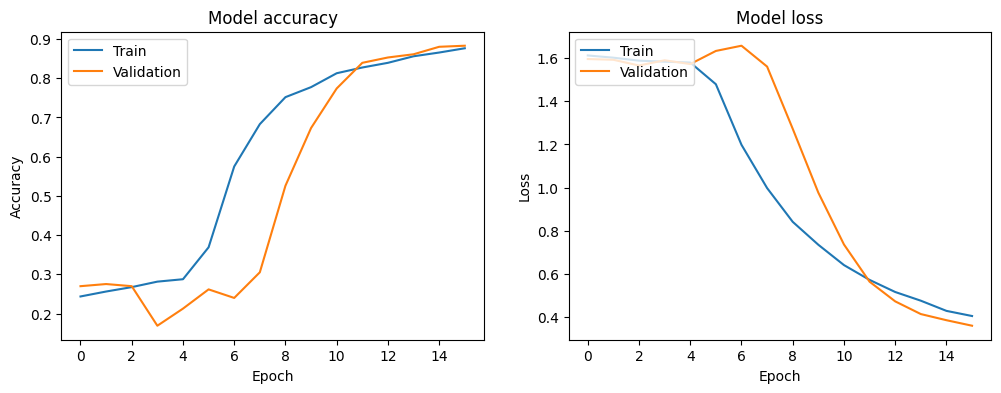

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# ADVANCE CODE - To open the computer Camera and predict the emotions 

In [ ]:
!pip install deepface


<IPython.core.display.Javascript object>

Saved to photo.jpg


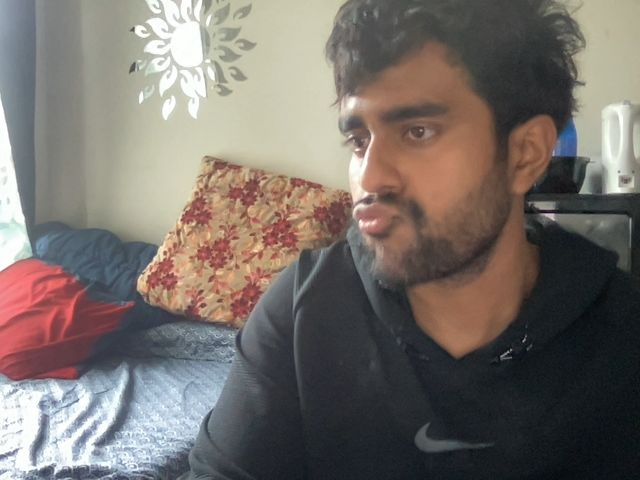

In [10]:

import cv2
from IPython.display import display, Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# capture the photo
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


<IPython.core.display.Javascript object>

Saved to photo.jpg


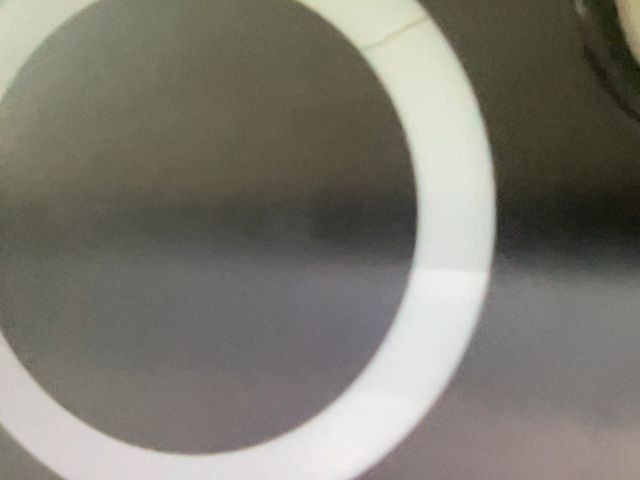

1/1 [==============================] - 0s 30ms/step
Predicted emotion: roses


In [13]:
import cv2
from IPython.display import display, Image
from tensorflow.keras.preprocessing import image as keras_image

# Capture the photo
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    display(Image(filename))

    # Preprocess the image
    img = keras_image.load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras_image.img_to_array(img)
    processed_img = (img_array / 127.5) - 1
    processed_img = tf.image.resize(processed_img, (IMG_SIZE, IMG_SIZE))
    processed_img = tf.expand_dims(processed_img, 0)

    # Make predictions
    predictions = model.predict(processed_img)
    predicted_label = tf.argmax(predictions, axis=1).numpy()[0]

    # Convert predicted label to emotion
    flower_names = metadata.features['label'].names
    predicted_emotion = flower_names[predicted_label]

    print('Predicted emotion:', predicted_emotion)

except Exception as err:
    print(str(err))


In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Load the FER2013 dataset
(train_dataset, validation_dataset, test_dataset), info = tfds.load(
    'fer2013',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Define the emotion classes
emotion_classes = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
num_classes = len(emotion_classes)

# Apply data normalization and augmentation
IMG_SIZE = 48  # FER2013 images are 48x48 grayscale
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_dataset = train_dataset.map(format_example)
validation_dataset = validation_dataset.map(format_example)
test_dataset = test_dataset.map(format_example)

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
])

# Shuffle and batch the data
train_batches = train_dataset.shuffle(1000).batch(BATCH_SIZE)
validation_batches = validation_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

# Build the model
model = Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Train the model
history = model.fit(train_batches, 
                    validation_data=validation_batches, 
                    epochs=5)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_batches)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


In [17]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Set up Spotify API client
client_id = "<your-client-id>"
client_secret = "<your-client-secret>"
redirect_uri = "<your-redirect-uri>"
scope = "user-read-playback-state,user-modify-playback-state"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=scope))

# Get the URI for the playlist or song based on predicted emotion
predicted_emotion = "happy"  # Replace with the predicted emotion
playlist_uri = emotion_to_music.get(predicted_emotion)

# Play the music
sp.start_playback(context_uri=playlist_uri)


KeyboardInterrupt: ignored

pip install spotipy

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import xgboost as xgb

# Load the FER2013 dataset
(train_dataset, validation_dataset, test_dataset), info = tfds.load(
    'fer2013',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Prepare the data for XGBoost
IMG_SIZE = 48  # FER2013 images are 48x48 grayscale

def preprocess_dataset(dataset):
    images = []
    labels = []
    for image, label in dataset:
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
        image = tf.reshape(image, [-1])  # Flatten the image
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

x_train, y_train = preprocess_dataset(train_dataset)
x_val, y_val = preprocess_dataset(validation_dataset)
x_test, y_test = preprocess_dataset(test_dataset)

# Train an XGBoost model
params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'merror',
}

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'validation')])

# Evaluate the model
dtest = xgb.DMatrix(x_test, label=y_test)
predictions = model.predict(dtest)
accuracy = np.sum(predictions == y_test) / len(y_test)
print('Test Accuracy:', accuracy)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 27.6 MB/s eta 0:00:00


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
